# Library

In [1]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install opendatasets

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Library to dataset
import opendatasets as od
import os
import zipfile
import numpy as np

# Surpress Warnings
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
# library visualization
import matplotlib.pyplot as plt

# Library Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

# Others
import shutil
import random

# Load dataset

In [4]:
# Load dataset
print("==========================Training Data====================")
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset/Peach/train",
    label_mode="categorical",
    class_names=['Peach___Bacterial_spot','Peach___healthy'],
    color_mode="rgb",
    batch_size=1,
    image_size=(256, 256),
    shuffle=True,
    seed=123
)
print("==========================Validation Data====================")
val_data = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset/Peach/valid",
    label_mode="categorical",
    class_names=['Peach___Bacterial_spot','Peach___healthy'],
    color_mode="rgb",
    batch_size=1,
    image_size=(256, 256),
    shuffle=True,
    seed=123
)

==========================Training Data====================
Found 3566 files belonging to 2 classes.
==========================Validation Data====================
Found 891 files belonging to 2 classes.


In [5]:
# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator(rescale = 1.0/256.)
test_datagen  = ImageDataGenerator(rescale = 1.0/256.)

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory("Dataset/Peach/train",
                                                    batch_size=20,
                                                    class_mode='categorical',
                                                    target_size=(224, 224))     
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory("Dataset/Peach/valid",
                                                         batch_size=20,
                                                         class_mode  = 'categorical',
                                                         target_size = (224, 224))

Found 3566 images belonging to 2 classes.
Found 891 images belonging to 2 classes.


# List Resource

In [6]:
# Check GPU
!nvidia-smi

Thu May 25 14:19:35 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 531.79                 Driver Version: 531.79       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060 L...  WDDM | 00000000:01:00.0  On |                  N/A |
| N/A   63C    P0               45W /  N/A|   4536MiB /  6144MiB |      8%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [7]:
# Lis physical devices
devices = tf.config.experimental.list_physical_devices("GPU")
devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [8]:
# Define the GPU strategy
mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


# Modelling Without Augmentation

## MobileNetV2 Model 1

In [9]:
# Difine the callbacks
# Save the best model
checkpoint_callback = ModelCheckpoint(filepath="Peach_MobileNetV2_model1_Based_Non_Augmented", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)

# Early stopping
early_stopping_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=20, verbose=1, restore_best_weights=True)

# Reduce learning rate
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

# Callbacks list
callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [10]:
# Define DIY Model
MobileNetV2_model = tf.keras.models.Sequential([
    # MobileNetV2 Layer
    MobileNetV2(include_top=False,weights='imagenet',input_shape=(224, 224, 3)),
    # Global Max Pooling Layer
    tf.keras.layers.GlobalMaxPooling2D(),
    # Drop Out Layer
    tf.keras.layers.Dropout(0.2),
    # 256 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    # Output
    tf.keras.layers.Dense(2, activation='softmax') 
  ])


# Compile Model
MobileNetV2_model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy']) 

# Model Summary
MobileNetV2_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_max_pooling2d (Globa  (None, 1280)             0         
 lMaxPooling2D)                                                  
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 2,586,434
Trainable params: 2,552,322
Non-

In [11]:
# Define the number of epochs
num_epochs = 100

# Train the model
history_MobileNetV2_model_1 = MobileNetV2_model.fit(train_generator, epochs=num_epochs, validation_data=validation_generator, callbacks=callbacks)

Epoch 1/100
179/179 [==============================] - ETA: 0s - loss: 0.3417 - accuracy: 0.9663
Epoch 1: val_accuracy improved from -inf to 0.62290, saving model to Peach_MobileNetV2_model1_Based_Non_Augmented


INFO:tensorflow:Assets written to: Peach_MobileNetV2_model1_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Peach_MobileNetV2_model1_Based_Non_Augmented\assets


179/179 [==============================] - 48s 224ms/step - loss: 0.3417 - accuracy: 0.9663 - val_loss: 2.0211 - val_accuracy: 0.6229 - lr: 0.0010
Epoch 2/100
179/179 [==============================] - ETA: 0s - loss: 0.0319 - accuracy: 0.9916
Epoch 2: val_accuracy improved from 0.62290 to 0.77329, saving model to Peach_MobileNetV2_model1_Based_Non_Augmented


INFO:tensorflow:Assets written to: Peach_MobileNetV2_model1_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Peach_MobileNetV2_model1_Based_Non_Augmented\assets


179/179 [==============================] - 38s 214ms/step - loss: 0.0319 - accuracy: 0.9916 - val_loss: 1.0102 - val_accuracy: 0.7733 - lr: 0.0010
Epoch 3/100
179/179 [==============================] - ETA: 0s - loss: 0.0320 - accuracy: 0.9910
Epoch 3: val_accuracy improved from 0.77329 to 0.97082, saving model to Peach_MobileNetV2_model1_Based_Non_Augmented


INFO:tensorflow:Assets written to: Peach_MobileNetV2_model1_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Peach_MobileNetV2_model1_Based_Non_Augmented\assets


179/179 [==============================] - 38s 213ms/step - loss: 0.0320 - accuracy: 0.9910 - val_loss: 0.1814 - val_accuracy: 0.9708 - lr: 0.0010
Epoch 4/100
179/179 [==============================] - ETA: 0s - loss: 0.0204 - accuracy: 0.9950
Epoch 4: val_accuracy improved from 0.97082 to 0.99551, saving model to Peach_MobileNetV2_model1_Based_Non_Augmented


INFO:tensorflow:Assets written to: Peach_MobileNetV2_model1_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Peach_MobileNetV2_model1_Based_Non_Augmented\assets


179/179 [==============================] - 38s 213ms/step - loss: 0.0204 - accuracy: 0.9950 - val_loss: 0.0229 - val_accuracy: 0.9955 - lr: 0.0010
Epoch 5/100
179/179 [==============================] - ETA: 0s - loss: 0.0359 - accuracy: 0.9888
Epoch 5: val_accuracy did not improve from 0.99551
179/179 [==============================] - 21s 116ms/step - loss: 0.0359 - accuracy: 0.9888 - val_loss: 0.1473 - val_accuracy: 0.9731 - lr: 0.0010
Epoch 6/100
179/179 [==============================] - ETA: 0s - loss: 0.0572 - accuracy: 0.9899
Epoch 6: val_accuracy did not improve from 0.99551
179/179 [==============================] - 20s 114ms/step - loss: 0.0572 - accuracy: 0.9899 - val_loss: 0.8931 - val_accuracy: 0.8889 - lr: 0.0010
Epoch 7/100
179/179 [==============================] - ETA: 0s - loss: 0.0258 - accuracy: 0.9950
Epoch 7: val_accuracy did not improve from 0.99551
179/179 [==============================] - 19s 108ms/step - loss: 0.0258 - accuracy: 0.9950 - val_loss: 4.0558 - va

INFO:tensorflow:Assets written to: Peach_MobileNetV2_model1_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Peach_MobileNetV2_model1_Based_Non_Augmented\assets


179/179 [==============================] - 38s 212ms/step - loss: 0.0110 - accuracy: 0.9972 - val_loss: 0.0020 - val_accuracy: 0.9989 - lr: 1.0000e-04
Epoch 11/100
179/179 [==============================] - ETA: 0s - loss: 0.0028 - accuracy: 0.9992
Epoch 11: val_accuracy did not improve from 0.99888
179/179 [==============================] - 20s 111ms/step - loss: 0.0028 - accuracy: 0.9992 - val_loss: 0.0108 - val_accuracy: 0.9978 - lr: 1.0000e-04
Epoch 12/100
179/179 [==============================] - ETA: 0s - loss: 0.0029 - accuracy: 0.9992
Epoch 12: val_accuracy did not improve from 0.99888
179/179 [==============================] - 20s 111ms/step - loss: 0.0029 - accuracy: 0.9992 - val_loss: 0.0149 - val_accuracy: 0.9966 - lr: 1.0000e-04
Epoch 13/100
179/179 [==============================] - ETA: 0s - loss: 0.0013 - accuracy: 0.9997
Epoch 13: val_accuracy did not improve from 0.99888
179/179 [==============================] - 20s 110ms/step - loss: 0.0013 - accuracy: 0.9997 - val

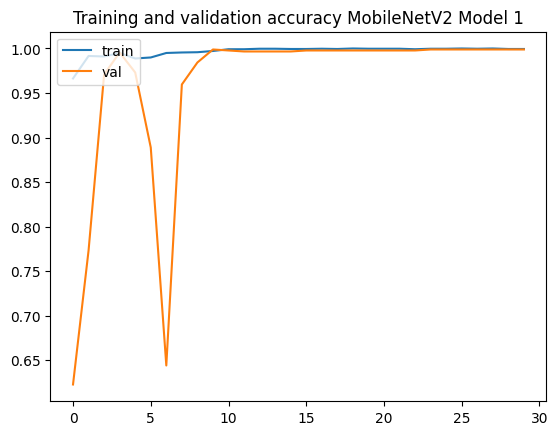

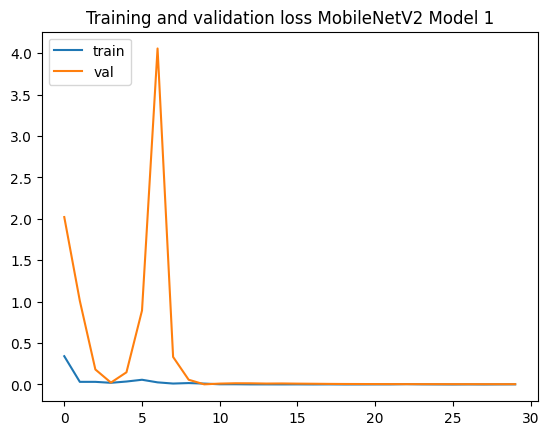

In [12]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history_MobileNetV2_model_1.history['accuracy' ]
val_acc  = history_MobileNetV2_model_1.history['val_accuracy' ]
loss     = history_MobileNetV2_model_1.history['loss' ]
val_loss = history_MobileNetV2_model_1.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  (epochs, acc )
plt.plot  (epochs, val_acc )
plt.title ('Training and validation accuracy MobileNetV2 Model 1')
plt.legend(['train', 'val'], loc='upper left')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  (epochs, loss)
plt.plot  (epochs, val_loss)
plt.title ('Training and validation loss MobileNetV2 Model 1')
plt.legend(['train', 'val'], loc='upper left')

## MobileNetV2 Model 2

In [13]:
# Difine the callbacks
# Save the best model
checkpoint_callback = ModelCheckpoint(filepath="Peach_MobileNetV2_model2_Based_Non_Augmented", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)

# Early stopping
early_stopping_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=20, verbose=1, restore_best_weights=True)

# Reduce learning rate
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

# Callbacks list
callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [14]:
# Define DIY Model
MobileNetV2_model_2 = tf.keras.models.Sequential([
    # MobileNetV2 Layer
    MobileNetV2(include_top=False,weights='imagenet',input_shape=(224, 224, 3)),
    # Global Average Pooling Layer
    tf.keras.layers.GlobalAveragePooling2D(),
    # Drop Out Layer
    tf.keras.layers.Dropout(0.2),
    # 256 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    # Output
    tf.keras.layers.Dense(2, activation='softmax') 
  ])


# Compile Model
MobileNetV2_model_2.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy']) 

# Model Summary
MobileNetV2_model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               327936    
                                                                 
 dense_3 (Dense)             (None, 2)                 514       
                                                                 
Total params: 2,586,434
Trainable params: 2,552,322
No

In [15]:
# Define the number of epochs
num_epochs = 100

# Train the model
history_MobileNetV2_model_2 = MobileNetV2_model_2.fit(train_generator, epochs=num_epochs, validation_data=validation_generator, callbacks=callbacks)

Epoch 1/100
179/179 [==============================] - ETA: 0s - loss: 0.1036 - accuracy: 0.9647
Epoch 1: val_accuracy improved from -inf to 0.81481, saving model to Peach_MobileNetV2_model2_Based_Non_Augmented


INFO:tensorflow:Assets written to: Peach_MobileNetV2_model2_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Peach_MobileNetV2_model2_Based_Non_Augmented\assets


179/179 [==============================] - 44s 215ms/step - loss: 0.1036 - accuracy: 0.9647 - val_loss: 2.4846 - val_accuracy: 0.8148 - lr: 0.0010
Epoch 2/100
179/179 [==============================] - ETA: 0s - loss: 0.0479 - accuracy: 0.9882
Epoch 2: val_accuracy did not improve from 0.81481
179/179 [==============================] - 21s 115ms/step - loss: 0.0479 - accuracy: 0.9882 - val_loss: 15.4385 - val_accuracy: 0.4848 - lr: 0.0010
Epoch 3/100
179/179 [==============================] - ETA: 0s - loss: 0.0328 - accuracy: 0.9899
Epoch 3: val_accuracy did not improve from 0.81481
179/179 [==============================] - 20s 114ms/step - loss: 0.0328 - accuracy: 0.9899 - val_loss: 4.7797 - val_accuracy: 0.4994 - lr: 0.0010
Epoch 4/100
179/179 [==============================] - ETA: 0s - loss: 0.0195 - accuracy: 0.9927
Epoch 4: val_accuracy improved from 0.81481 to 0.83053, saving model to Peach_MobileNetV2_model2_Based_Non_Augmented


INFO:tensorflow:Assets written to: Peach_MobileNetV2_model2_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Peach_MobileNetV2_model2_Based_Non_Augmented\assets


179/179 [==============================] - 39s 215ms/step - loss: 0.0195 - accuracy: 0.9927 - val_loss: 0.8952 - val_accuracy: 0.8305 - lr: 0.0010
Epoch 5/100
179/179 [==============================] - ETA: 0s - loss: 0.0200 - accuracy: 0.9933
Epoch 5: val_accuracy did not improve from 0.83053
179/179 [==============================] - 21s 114ms/step - loss: 0.0200 - accuracy: 0.9933 - val_loss: 26.2340 - val_accuracy: 0.4848 - lr: 0.0010
Epoch 6/100
179/179 [==============================] - ETA: 0s - loss: 0.0433 - accuracy: 0.9893
Epoch 6: val_accuracy did not improve from 0.83053
179/179 [==============================] - 21s 115ms/step - loss: 0.0433 - accuracy: 0.9893 - val_loss: 5.7363 - val_accuracy: 0.4860 - lr: 0.0010
Epoch 7/100
179/179 [==============================] - ETA: 0s - loss: 0.0248 - accuracy: 0.9936
Epoch 7: val_accuracy did not improve from 0.83053
179/179 [==============================] - 21s 117ms/step - loss: 0.0248 - accuracy: 0.9936 - val_loss: 3.8264 - v

INFO:tensorflow:Assets written to: Peach_MobileNetV2_model2_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Peach_MobileNetV2_model2_Based_Non_Augmented\assets


179/179 [==============================] - 82s 461ms/step - loss: 0.0226 - accuracy: 0.9961 - val_loss: 0.5643 - val_accuracy: 0.9203 - lr: 0.0010
Epoch 10/100
179/179 [==============================] - ETA: 0s - loss: 0.0119 - accuracy: 0.9958
Epoch 10: val_accuracy improved from 0.92031 to 0.94949, saving model to Peach_MobileNetV2_model2_Based_Non_Augmented


INFO:tensorflow:Assets written to: Peach_MobileNetV2_model2_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Peach_MobileNetV2_model2_Based_Non_Augmented\assets


179/179 [==============================] - 40s 224ms/step - loss: 0.0119 - accuracy: 0.9958 - val_loss: 0.5351 - val_accuracy: 0.9495 - lr: 0.0010
Epoch 11/100
179/179 [==============================] - ETA: 0s - loss: 0.0136 - accuracy: 0.9966
Epoch 11: val_accuracy did not improve from 0.94949
179/179 [==============================] - 21s 115ms/step - loss: 0.0136 - accuracy: 0.9966 - val_loss: 0.1840 - val_accuracy: 0.9439 - lr: 0.0010
Epoch 12/100
179/179 [==============================] - ETA: 0s - loss: 0.0116 - accuracy: 0.9958
Epoch 12: val_accuracy improved from 0.94949 to 0.98429, saving model to Peach_MobileNetV2_model2_Based_Non_Augmented


INFO:tensorflow:Assets written to: Peach_MobileNetV2_model2_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Peach_MobileNetV2_model2_Based_Non_Augmented\assets


179/179 [==============================] - 38s 213ms/step - loss: 0.0116 - accuracy: 0.9958 - val_loss: 0.1820 - val_accuracy: 0.9843 - lr: 0.0010
Epoch 13/100
179/179 [==============================] - ETA: 0s - loss: 0.0032 - accuracy: 0.9989
Epoch 13: val_accuracy improved from 0.98429 to 0.98653, saving model to Peach_MobileNetV2_model2_Based_Non_Augmented


INFO:tensorflow:Assets written to: Peach_MobileNetV2_model2_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Peach_MobileNetV2_model2_Based_Non_Augmented\assets


179/179 [==============================] - 95s 532ms/step - loss: 0.0032 - accuracy: 0.9989 - val_loss: 0.2548 - val_accuracy: 0.9865 - lr: 0.0010
Epoch 14/100
179/179 [==============================] - ETA: 0s - loss: 7.5059e-04 - accuracy: 0.9997
Epoch 14: val_accuracy improved from 0.98653 to 0.98878, saving model to Peach_MobileNetV2_model2_Based_Non_Augmented


INFO:tensorflow:Assets written to: Peach_MobileNetV2_model2_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Peach_MobileNetV2_model2_Based_Non_Augmented\assets


179/179 [==============================] - 40s 221ms/step - loss: 7.5059e-04 - accuracy: 0.9997 - val_loss: 0.1404 - val_accuracy: 0.9888 - lr: 0.0010
Epoch 15/100
179/179 [==============================] - ETA: 0s - loss: 0.0011 - accuracy: 0.9997
Epoch 15: val_accuracy improved from 0.98878 to 0.99214, saving model to Peach_MobileNetV2_model2_Based_Non_Augmented


INFO:tensorflow:Assets written to: Peach_MobileNetV2_model2_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Peach_MobileNetV2_model2_Based_Non_Augmented\assets


179/179 [==============================] - 40s 225ms/step - loss: 0.0011 - accuracy: 0.9997 - val_loss: 0.1130 - val_accuracy: 0.9921 - lr: 0.0010
Epoch 16/100
179/179 [==============================] - ETA: 0s - loss: 0.0210 - accuracy: 0.9941
Epoch 16: val_accuracy did not improve from 0.99214
179/179 [==============================] - 21s 113ms/step - loss: 0.0210 - accuracy: 0.9941 - val_loss: 0.3940 - val_accuracy: 0.9012 - lr: 0.0010
Epoch 17/100
179/179 [==============================] - ETA: 0s - loss: 0.0187 - accuracy: 0.9941
Epoch 17: val_accuracy did not improve from 0.99214
179/179 [==============================] - 20s 113ms/step - loss: 0.0187 - accuracy: 0.9941 - val_loss: 0.0929 - val_accuracy: 0.9877 - lr: 0.0010
Epoch 18/100
179/179 [==============================] - ETA: 0s - loss: 0.0024 - accuracy: 0.9989
Epoch 18: val_accuracy did not improve from 0.99214
179/179 [==============================] - 21s 115ms/step - loss: 0.0024 - accuracy: 0.9989 - val_loss: 0.172

INFO:tensorflow:Assets written to: Peach_MobileNetV2_model2_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Peach_MobileNetV2_model2_Based_Non_Augmented\assets


179/179 [==============================] - 39s 219ms/step - loss: 6.0155e-04 - accuracy: 1.0000 - val_loss: 0.0329 - val_accuracy: 0.9933 - lr: 1.0000e-04
Epoch 27/100
179/179 [==============================] - ETA: 0s - loss: 0.0034 - accuracy: 0.9992
Epoch 27: val_accuracy improved from 0.99327 to 0.99439, saving model to Peach_MobileNetV2_model2_Based_Non_Augmented


INFO:tensorflow:Assets written to: Peach_MobileNetV2_model2_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Peach_MobileNetV2_model2_Based_Non_Augmented\assets


179/179 [==============================] - 39s 217ms/step - loss: 0.0034 - accuracy: 0.9992 - val_loss: 0.0284 - val_accuracy: 0.9944 - lr: 1.0000e-04
Epoch 28/100
179/179 [==============================] - ETA: 0s - loss: 6.5052e-04 - accuracy: 1.0000
Epoch 28: val_accuracy improved from 0.99439 to 0.99551, saving model to Peach_MobileNetV2_model2_Based_Non_Augmented


INFO:tensorflow:Assets written to: Peach_MobileNetV2_model2_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Peach_MobileNetV2_model2_Based_Non_Augmented\assets


179/179 [==============================] - 39s 217ms/step - loss: 6.5052e-04 - accuracy: 1.0000 - val_loss: 0.0249 - val_accuracy: 0.9955 - lr: 1.0000e-04
Epoch 29/100
179/179 [==============================] - ETA: 0s - loss: 0.0021 - accuracy: 0.9997
Epoch 29: val_accuracy improved from 0.99551 to 0.99776, saving model to Peach_MobileNetV2_model2_Based_Non_Augmented


INFO:tensorflow:Assets written to: Peach_MobileNetV2_model2_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Peach_MobileNetV2_model2_Based_Non_Augmented\assets


179/179 [==============================] - 39s 215ms/step - loss: 0.0021 - accuracy: 0.9997 - val_loss: 0.0060 - val_accuracy: 0.9978 - lr: 1.0000e-04
Epoch 30/100
179/179 [==============================] - ETA: 0s - loss: 6.3564e-04 - accuracy: 1.0000
Epoch 30: val_accuracy did not improve from 0.99776
179/179 [==============================] - 21s 116ms/step - loss: 6.3564e-04 - accuracy: 1.0000 - val_loss: 0.0090 - val_accuracy: 0.9966 - lr: 1.0000e-04
Epoch 31/100
179/179 [==============================] - ETA: 0s - loss: 0.0012 - accuracy: 0.9992  
Epoch 31: val_accuracy did not improve from 0.99776
179/179 [==============================] - 21s 116ms/step - loss: 0.0012 - accuracy: 0.9992 - val_loss: 0.0101 - val_accuracy: 0.9966 - lr: 1.0000e-04
Epoch 32/100
179/179 [==============================] - ETA: 0s - loss: 2.7358e-04 - accuracy: 1.0000
Epoch 32: val_accuracy did not improve from 0.99776
179/179 [==============================] - 21s 117ms/step - loss: 2.7358e-04 - accu

INFO:tensorflow:Assets written to: Peach_MobileNetV2_model2_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Peach_MobileNetV2_model2_Based_Non_Augmented\assets


179/179 [==============================] - 41s 228ms/step - loss: 0.0015 - accuracy: 0.9997 - val_loss: 0.0028 - val_accuracy: 0.9989 - lr: 1.0000e-05
Epoch 41/100
179/179 [==============================] - ETA: 0s - loss: 4.9435e-04 - accuracy: 1.0000
Epoch 41: val_accuracy did not improve from 0.99888
179/179 [==============================] - 21s 117ms/step - loss: 4.9435e-04 - accuracy: 1.0000 - val_loss: 0.0027 - val_accuracy: 0.9989 - lr: 1.0000e-05
Epoch 42/100
179/179 [==============================] - ETA: 0s - loss: 0.0014 - accuracy: 0.9997
Epoch 42: val_accuracy did not improve from 0.99888
179/179 [==============================] - 20s 114ms/step - loss: 0.0014 - accuracy: 0.9997 - val_loss: 0.0031 - val_accuracy: 0.9989 - lr: 1.0000e-05
Epoch 43/100
179/179 [==============================] - ETA: 0s - loss: 1.9120e-04 - accuracy: 1.0000
Epoch 43: val_accuracy did not improve from 0.99888
179/179 [==============================] - 20s 112ms/step - loss: 1.9120e-04 - accura

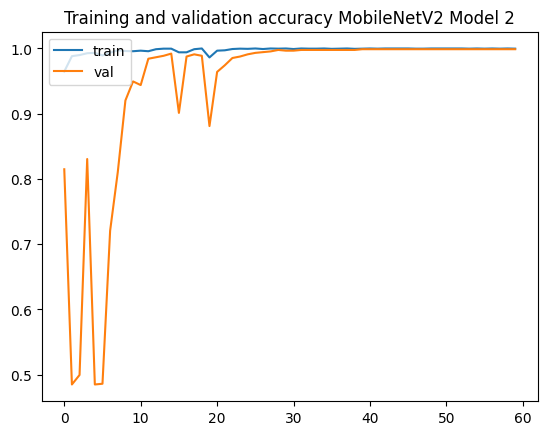

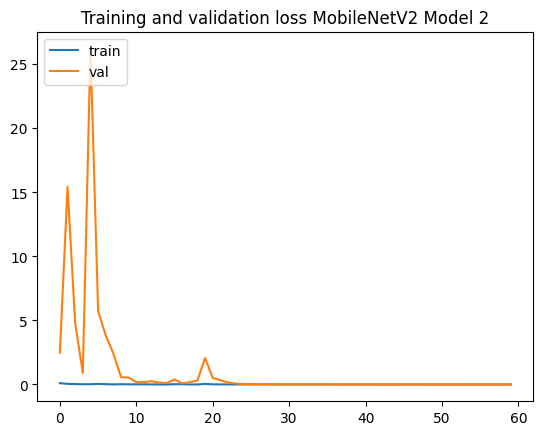

In [16]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history_MobileNetV2_model_2.history['accuracy' ]
val_acc  = history_MobileNetV2_model_2.history['val_accuracy' ]
loss     = history_MobileNetV2_model_2.history['loss' ]
val_loss = history_MobileNetV2_model_2.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  (epochs, acc )
plt.plot  (epochs, val_acc )
plt.title ('Training and validation accuracy MobileNetV2 Model 2')
plt.legend(['train', 'val'], loc='upper left')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  (epochs, loss)
plt.plot  (epochs, val_loss)
plt.title ('Training and validation loss MobileNetV2 Model 2')
plt.legend(['train', 'val'], loc='upper left')